<center><h1> Introduction to DC-GAN </h1></center>

<h3> 1. The Generator </h3>

<ul>
    <li>Don't use any poooling layers.</li>
    <li>Don't use fully connnected layers, directly connect to discriminator</li>
    <li>Reshape the first layer into a 4d tensor</li>
    <li>Apply BatchNorm on all layers, except generator output layer</li>
    <li>Use ReLU activation in all layers, except the output layer - use tanh</li> 
</ul>

<h3> 2. The Discriminator </h3>
<ul>
    <li>flatten last layer and send to a single sigmoid output</li>
    <li>Apply BatchNorm to all layers, except input layer</li>
    <li>Use LeakyReLU</li>
    <li>Discriminator can be improved</li>
</ul>

Some other points to remember - 
<ul>
    <li>Use mini-batch SGD (batch_size = 128) with ADAM (Beta_1 = 0.5)</li>
    <li>Weight initilization - zero centered normal distribution with std = 0.02</li>
    <li>In Leaky ReLU the slope = 0.2</li>
    <li>Learning rate = 0.0002</li>
</ul>

In [2]:
import random
import os
import numpy as np
import matplotlib.pyplot as plt
import collections
from tqdm.notebook import tqdm
from tabulate import tabulate

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch import optim

import torchvision.datasets as dset
from torchvision import transforms
from torchvision import utils as vutils

writer = SummaryWriter("runs/DCGAN")

# seed = 26
# random.seed(seed)
# torch.manual_seed(seed)
# torch.use_deterministic_algorithms(True)

data_path = "../Variational Autoencoder - Anime Face Generation/Dataset_Anime"
workers = 3
BATCH_SIZE = 64
IMAGE_SIZE = 64
NUM_CHANNELS = 3 # nc
LATENT_DIMENSION = 100 # nz
NUM_GEN_FM = 64 # ngf
NUM_DIS_FM = 64 # ndf
EPOCHS = 100
lr = 0.0002
beta1 = 0.5
NUM_GPU = torch.cuda.device_count()

print(NUM_GPU)

1


In [3]:
dataset = dset.ImageFolder(root = data_path,
                          transform = transforms.Compose([
                              transforms.Resize(IMAGE_SIZE),
                              transforms.CenterCrop(IMAGE_SIZE),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                          ]))
dataloader = DataLoader(dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = workers)
device = torch.device("cuda:0" if (torch.cuda.is_available() and NUM_GPU > 0) else "cpu")

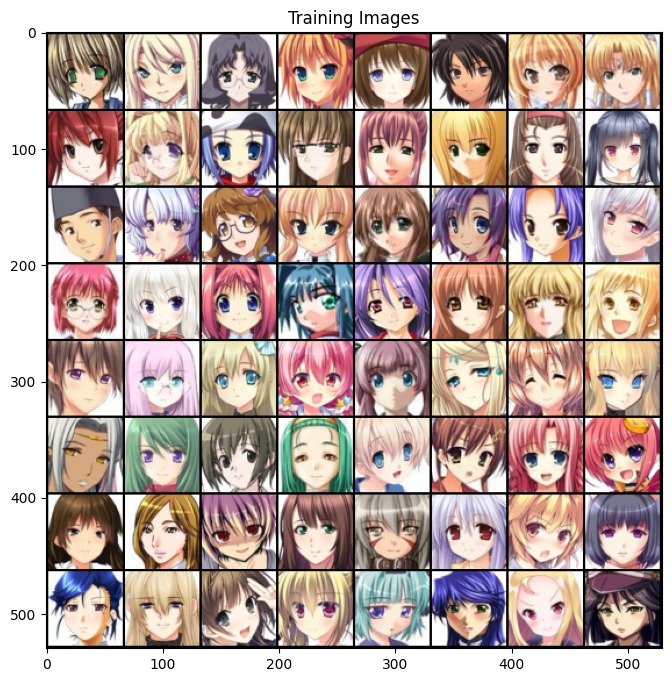

In [4]:
real_batch = next(iter(dataloader))
plt.figure(figsize = (8,8))
plt.axis("on")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [5]:
def init_weights(model):
    names_layers = [(name,layer) for name, layer in model.named_children()]
#     layers_init = {}
    j=0
    for i in range(len(names_layers)):
        if("Activation" in names_layers[i][0]):
            while (j < i):
                if("LeakyReLU" in names_layers[i][0]):
                    nn.init.kaiming_normal_(names_layers[j][1].weight,a = names_layers[i][1].negative_slope, mode='fan_out') if ("Conv" in names_layers[j][0]) else nn.init.normal_(names_layers[j][1].weight, 1.0, 0.02)
                elif("ReLU" in names_layers[i][0]):
                    nn.init.kaiming_normal_(names_layers[j][1].weight, mode='fan_out') if ("Conv" in names_layers[j][0]) else nn.init.normal_(names_layers[j][1].weight, 1.0, 0.02)
                else:
                    nn.init.xavier_normal_(names_layers[j][1].weight)    
                nn.init.constant_(names_layers[j][1].bias, 0)
#                 layers_init[names_layers[j][0]] = 1
                j+=1
            j+=1
            
#     print(layers_init)

In [6]:
class Generator(nn.Module):
    
    def __init__(self, ngpu, gen_arch):
        
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.layer_idx = 0
        self.architecture = collections.OrderedDict()
        print("Compiling Model...")
        self.model = self.compileModel(gen_arch)
        print("Initializing Weights & Biases...")
        init_weights(self.model)
        print("Complete!")
        
    
    def addConvTransposeLayer(self, name, params):
        self.architecture.update({name: nn.ConvTranspose2d(in_channels = params.get("in_channels",0), 
                                                           out_channels = params.get("out_channels",0),
                                                           kernel_size = params.get("k_size",0),
                                                           stride = params.get("stride",1),
                                                           padding = params.get("padding",0), 
                                                           output_padding = params.get("out_padding",0),
                                                           groups=params.get("groups",1), 
                                                           bias=params.get("bias",True), 
                                                           dilation=params.get("dilation",1), 
                                                           padding_mode='zeros',
                                                           device=None,
                                                           dtype=None)})
    def addBatchNormLayer(self, name, params):
        self.architecture.update({name: nn.BatchNorm2d(params.get("num_features",0))})
    
    def addActivationLayer(self, name, params = {}):
        activation = name.split("_")[3]
        
        if(activation == "ReLU"):
            layer = nn.ReLU(params.get("inplace",False))
        elif(activation == "Tanh"):
            layer = nn.Tanh()
        elif(activation == "LeakyReLU"):
            layer = nn.LeakyReLU(params.get("slope",0.01), params.get("inplace",False))
        elif(activation == "Sigmoid"):
            layer = nn.Sigmoid()
        
        else:
            raise Exception(f"The Activation Function, {activation} is not defined")
            
        self.architecture.update({name: layer})
        
    def compileModel(self, gen_arch):
        for layer in gen_arch:
            name = layer[0].split("_")[2]
            if(name == "ConvTranspose2d"):
                self.addConvTransposeLayer(layer[0], layer[1])
            elif(name == "BatchNorm2d"):
                self.addBatchNormLayer(layer[0],layer[1])
            elif(name == "Activation"):
                self.addActivationLayer(layer[0],layer[1])
                
        return nn.Sequential(self.architecture)
        
    def forward(self, input):
        return self.model(input)

In [7]:
def getParams(keys,values):
    return {keys[i]:values[i] for i in range(len(values))}


tconv_keys = ["in_channels","out_channels","k_size","stride","padding","out_padding","groups","bias","dilation"]
bn_keys = ["num_features"]
relu_keys = ["inplace"]
leakyRelu_keys = ["slope","inplace"]

gen_arch = [("_1_ConvTranspose2d_", getParams(tconv_keys, [LATENT_DIMENSION, NUM_GEN_FM*8, 4, 1, 0])),
            ("_1_BatchNorm2d_", getParams(bn_keys, [NUM_GEN_FM*8])),
            ("_1_Activation_ReLU_", getParams(relu_keys, [True])),
            
            ("_2_ConvTranspose2d_", getParams(tconv_keys, [NUM_GEN_FM*8, NUM_GEN_FM*4, 4, 2, 1])),
            ("_2_BatchNorm2d_", getParams(bn_keys, [NUM_GEN_FM*4])),
            ("_2_Activation_ReLU_", getParams(relu_keys, [True])),
            
            ("_3_ConvTranspose2d_", getParams(tconv_keys, [NUM_GEN_FM*4, NUM_GEN_FM*2, 4, 2, 1])),
            ("_3_BatchNorm2d_", getParams(bn_keys, [NUM_GEN_FM*2])),
            ("_3_Activation_ReLU_", getParams(relu_keys, [True])),
            
            ("_4_ConvTranspose2d_", getParams(tconv_keys, [NUM_GEN_FM*2, NUM_GEN_FM, 4, 2, 1])),
            ("_4_BatchNorm2d_", getParams(bn_keys, [NUM_GEN_FM])),
            ("_4_Activation_ReLU_", getParams(relu_keys, [True])),
            
            ("_5_ConvTranspose2d_", getParams(tconv_keys, [NUM_GEN_FM, NUM_CHANNELS, 4, 2, 1])),
            ("_5_Activation_Tanh_", {})
           ]

In [8]:
generator = Generator(NUM_GPU, gen_arch).to(device)

Compiling Model...
Initializing Weights & Biases...
Complete!


In [9]:
class Discriminator(nn.Module):
    def __init__(self, ngpu, des_arch):
        
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.architecture = collections.OrderedDict()
        print("Compiling Model...")
        self.model = self.compileModel(des_arch)
        print("Initializing Weights & Biases...")
        init_weights(self.model)
        print("Complete!")
        
    
    def addConvLayer(self, name, params):
        self.architecture.update({name: nn.Conv2d(in_channels = params.get("in_channels",0), 
                                                           out_channels = params.get("out_channels",0),
                                                           kernel_size = params.get("k_size",0),
                                                           stride = params.get("stride",1),
                                                           padding = params.get("padding",0), 
                                                           groups=params.get("groups",1), 
                                                           bias=params.get("bias",True), 
                                                           dilation=params.get("dilation",1), 
                                                           padding_mode='zeros',
                                                           device=None,
                                                           dtype=None)})
    def addBatchNormLayer(self, name, params):
        self.architecture.update({name: nn.BatchNorm2d(params.get("num_features",0))})
    
    def addActivationLayer(self, name, params = {}):
        activation = name.split("_")[3]
        
        if(activation == "ReLU"):
            layer = nn.ReLU(params.get("inplace",False))
        elif(activation == "Tanh"):
            layer = nn.Tanh()
        elif(activation == "LeakyReLU"):
            layer = nn.LeakyReLU(params.get("slope",0.01), params.get("inplace",False))
        elif(activation == "Sigmoid"):
            layer = nn.Sigmoid()
        
        else:
            raise Exception(f"The Activation Function, {activation} is not defined")
            
        self.architecture.update({name: layer})
        
    def compileModel(self, gen_arch):
        for layer in gen_arch:
            name = layer[0].split("_")[2]
            if(name == "Conv2d"):
                self.addConvLayer(layer[0], layer[1])
            elif(name == "BatchNorm2d"):
                self.addBatchNormLayer(layer[0],layer[1])
            elif(name == "Activation"):
                self.addActivationLayer(layer[0],layer[1])
                
        return nn.Sequential(self.architecture)
        
    def forward(self, input):
        return self.model(input)    

In [10]:
slope = 0.2
conv_keys = ["in_channels","out_channels","k_size","stride","padding","groups","bias","dilation"]
bn_keys = ["num_features"]
relu_keys = ["inplace"]
leakyRelu_keys = ["slope","inplace"]

des_arch = [("_1_Conv2d_", getParams(conv_keys, [NUM_CHANNELS, NUM_DIS_FM, 4, 2, 1])),
            ("_1_Activation_LeakyReLU_", getParams(leakyRelu_keys, [slope,True])),
            
            ("_2_Conv2d_", getParams(conv_keys, [NUM_DIS_FM, NUM_DIS_FM*2, 4, 2, 1])),
            ("_2_BatchNorm2d_", getParams(bn_keys, [NUM_DIS_FM*2])),
            ("_2_Activation_LeakyReLU_", getParams(leakyRelu_keys, [slope,True])),
            
            ("_3_Conv2d_", getParams(conv_keys, [NUM_DIS_FM*2, NUM_DIS_FM*4, 4, 2, 1])),
            ("_3_BatchNorm2d_", getParams(bn_keys, [NUM_GEN_FM*4])),
            ("_3_Activation_LeakyReLU_", getParams(leakyRelu_keys, [slope,True])),
            
            ("_4_Conv2d_", getParams(conv_keys, [NUM_DIS_FM*4, NUM_DIS_FM*8, 4, 2, 1])),
            ("_4_BatchNorm2d_", getParams(bn_keys, [NUM_DIS_FM*8])),
            ("_4_Activation_LeakyReLU_", getParams(leakyRelu_keys, [slope,True])),
            
            ("_5_Conv2d_", getParams(conv_keys, [NUM_DIS_FM*8, 1, 4, 1, 0])),
            ("_5_Activation_Sigmoid_", {})
           ]

In [11]:
discriminator = Discriminator(NUM_GPU, des_arch).to(device)

Compiling Model...
Initializing Weights & Biases...
Complete!


In [12]:
loss = nn.BCELoss()
label_map = {"real":1, "fake":0}
fixed_noise = torch.randn(64, LATENT_DIMENSION, 1, 1, device=device)

optimizerD = optim.Adam(discriminator.parameters(), lr = lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(generator.parameters(), lr = lr, betas=(beta1, 0.999))

writer.add_graph(discriminator, real_batch[0].to(device))
writer.add_graph(generator, fixed_noise.to(device))

total_steps = len(dataloader)

In [ ]:
def save_imgs(epoch, batch_num, batch, path = "./Generator_Progress/"):
    name = path + "Epoch_" + str(epoch) + "_" + str(batch_num) + ".png"
    img_grid = vutils.make_grid(fake_imgs.to(device)[:64], padding=2, normalize=True).cpu()
    vutils.save_image(img_grid, name)
    return

D_losses = []
G_losses = []

for epoch in range(EPOCHS):
    
    running_DLoss = 0
    running_GLoss = 0
    print("EPOCH: [%d/%d]" % (epoch,EPOCHS))
    for i, data in enumerate(tqdm(dataloader, leave=False), 0):
#         ---------------------------
#         Training the Discriminator
#         --------------------------- 
        discriminator.zero_grad()
        real_imgs = data[0].to(device)
        batch_size = real_imgs.size(0)
        
        y_true = torch.full((batch_size,), label_map["real"], dtype=torch.float, device = device)
        y_pred = discriminator(real_imgs).view(-1) #.view)(-1) for ensuring that y_pred has 1 dimension, i.e. its flattened
        
        d_errorR = loss(y_pred, y_true)
        d_errorR.backward()
        D_x = y_pred.mean().item() # 1st term in loss function
        
        z = torch.randn(batch_size, LATENT_DIMENSION, 1, 1, device = device)
        fake_imgs = generator(z)
        
        y_true.fill_(label_map["fake"])
        y_pred = discriminator(fake_imgs.detach()).view(-1)
        
        d_errorF = loss(y_pred, y_true)
        d_errorF.backward()
        D_Gz1 = y_pred.mean().item() # 2nd term in loss function
        
        d_error = d_errorR + d_errorF # Total Discriminator Loss
        optimizerD.step()
        
#         -----------------------
#         Training The Generator
#         -----------------------
        generator.zero_grad()
        
        y_true.fill_(label_map["real"]) # Generator wants to generate real images
        y_pred = discriminator(fake_imgs).view(-1) # Get Predictions again as discriminator is updated
        g_error = loss(y_pred, y_true)
        g_error.backward()
        D_Gz2 = y_pred.mean().item()
        optimizerG.step()
        
        running_DLoss += d_error.item()
        running_GLoss += g_error.item()
        if (i%50 == 0):
            save_imgs(epoch, i, fake_imgs)
            D_losses.append(d_error.item())
            G_losses.append(g_error.item())
            headers = ["Loss_D", "Loss_G", "D(x)", "D(G(z))_1", "D(G(z))_2"]
            values = [[D_losses[-1], G_losses[-1], D_x, D_Gz1, D_Gz2]]
            writer.add_scalars("Discriminator & Generator Loss", {"Discriminator Loss": running_DLoss/50,
                                                                 "Generator Loss": running_GLoss/50}, epoch*total_steps*i)
            print(tabulate(values, headers=headers, tablefmt='grid'))
        

writer.close()

EPOCH: [0/100]


  0%|          | 0/994 [00:00<?, ?it/s]

+----------+----------+----------+-------------+-------------+
|   Loss_D |   Loss_G |     D(x) |   D(G(z))_1 |   D(G(z))_2 |
+==========+==========+==========+=============+=============+
|  1.62988 |  2.57203 | 0.375443 |    0.390571 |   0.0907343 |
+----------+----------+----------+-------------+-------------+
+-----------+----------+----------+-------------+-------------+
|    Loss_D |   Loss_G |     D(x) |   D(G(z))_1 |   D(G(z))_2 |
+===========+==========+==========+=============+=============+
| 0.0247376 |  15.3429 | 0.979993 | 2.94196e-06 | 4.76087e-07 |
+-----------+----------+----------+-------------+-------------+
+----------+----------+---------+-------------+-------------+
|   Loss_D |   Loss_G |    D(x) |   D(G(z))_1 |   D(G(z))_2 |
+==========+==========+=========+=============+=============+
| 0.987319 |  16.3133 | 0.52422 | 3.65916e-06 | 2.11264e-07 |
+----------+----------+---------+-------------+-------------+
+----------+----------+----------+-------------+-------

  0%|          | 0/994 [00:00<?, ?it/s]

+----------+----------+----------+-------------+-------------+
|   Loss_D |   Loss_G |     D(x) |   D(G(z))_1 |   D(G(z))_2 |
+==========+==========+==========+=============+=============+
| 0.400047 |  6.38681 | 0.918027 |    0.227049 |  0.00285109 |
+----------+----------+----------+-------------+-------------+
+----------+----------+----------+-------------+-------------+
|   Loss_D |   Loss_G |     D(x) |   D(G(z))_1 |   D(G(z))_2 |
+==========+==========+==========+=============+=============+
| 0.547603 |  5.05642 | 0.786395 |    0.172813 |   0.0121967 |
+----------+----------+----------+-------------+-------------+
+----------+----------+----------+-------------+-------------+
|   Loss_D |   Loss_G |     D(x) |   D(G(z))_1 |   D(G(z))_2 |
+==========+==========+==========+=============+=============+
|  1.15146 |  9.71729 | 0.451316 |  3.2296e-05 |  0.00018707 |
+----------+----------+----------+-------------+-------------+
+----------+----------+---------+-------------+--------

  0%|          | 0/994 [00:00<?, ?it/s]

+----------+----------+----------+-------------+-------------+
|   Loss_D |   Loss_G |     D(x) |   D(G(z))_1 |   D(G(z))_2 |
+==========+==========+==========+=============+=============+
| 0.149007 |  3.39264 | 0.892887 |   0.0193455 |   0.0709412 |
+----------+----------+----------+-------------+-------------+
+----------+----------+---------+-------------+-------------+
|   Loss_D |   Loss_G |    D(x) |   D(G(z))_1 |   D(G(z))_2 |
+==========+==========+=========+=============+=============+
| 0.349414 |  5.96105 | 0.89482 |    0.180585 |   0.0045861 |
+----------+----------+---------+-------------+-------------+
+----------+----------+----------+-------------+-------------+
|   Loss_D |   Loss_G |     D(x) |   D(G(z))_1 |   D(G(z))_2 |
+==========+==========+==========+=============+=============+
| 0.284271 |  4.94278 | 0.821968 |   0.0259488 |   0.0101004 |
+----------+----------+----------+-------------+-------------+
+----------+----------+----------+-------------+------------

  0%|          | 0/994 [00:00<?, ?it/s]

+----------+----------+----------+-------------+-------------+
|   Loss_D |   Loss_G |     D(x) |   D(G(z))_1 |   D(G(z))_2 |
+==========+==========+==========+=============+=============+
| 0.280563 |  8.40901 | 0.970472 |    0.180854 | 0.000566806 |
+----------+----------+----------+-------------+-------------+
+----------+----------+----------+-------------+-------------+
|   Loss_D |   Loss_G |     D(x) |   D(G(z))_1 |   D(G(z))_2 |
+==========+==========+==========+=============+=============+
| 0.234871 |   6.9674 | 0.967672 |    0.168024 |  0.00160415 |
+----------+----------+----------+-------------+-------------+
+----------+----------+----------+-------------+-------------+
|   Loss_D |   Loss_G |     D(x) |   D(G(z))_1 |   D(G(z))_2 |
+==========+==========+==========+=============+=============+
| 0.448218 |  8.52004 | 0.762258 |   0.0031956 |  0.00056485 |
+----------+----------+----------+-------------+-------------+
+----------+----------+----------+-------------+-------

  0%|          | 0/994 [00:00<?, ?it/s]

+----------+----------+----------+-------------+-------------+
|   Loss_D |   Loss_G |     D(x) |   D(G(z))_1 |   D(G(z))_2 |
+==========+==========+==========+=============+=============+
|  1.86099 |  11.7465 | 0.999577 |    0.688831 | 0.000109847 |
+----------+----------+----------+-------------+-------------+
+----------+----------+----------+-------------+-------------+
|   Loss_D |   Loss_G |     D(x) |   D(G(z))_1 |   D(G(z))_2 |
+==========+==========+==========+=============+=============+
| 0.315134 |  6.43275 | 0.851408 |    0.076423 |   0.0033969 |
+----------+----------+----------+-------------+-------------+
+----------+----------+----------+-------------+-------------+
|   Loss_D |   Loss_G |     D(x) |   D(G(z))_1 |   D(G(z))_2 |
+==========+==========+==========+=============+=============+
| 0.358949 |  10.0252 | 0.999068 |    0.257173 | 0.000151602 |
+----------+----------+----------+-------------+-------------+
+----------+----------+----------+-------------+-------

  0%|          | 0/994 [00:00<?, ?it/s]

+----------+----------+---------+-------------+-------------+
|   Loss_D |   Loss_G |    D(x) |   D(G(z))_1 |   D(G(z))_2 |
+==========+==========+=========+=============+=============+
|  0.38999 |  3.77751 | 0.75012 |  0.00994469 |   0.0505886 |
+----------+----------+---------+-------------+-------------+
+----------+----------+----------+-------------+-------------+
|   Loss_D |   Loss_G |     D(x) |   D(G(z))_1 |   D(G(z))_2 |
+==========+==========+==========+=============+=============+
| 0.111505 |  6.45166 | 0.949291 |   0.0358684 |   0.0043368 |
+----------+----------+----------+-------------+-------------+
+-----------+----------+---------+-------------+-------------+
|    Loss_D |   Loss_G |    D(x) |   D(G(z))_1 |   D(G(z))_2 |
+===========+==========+=========+=============+=============+
| 0.0313688 |  7.06117 | 0.99653 |   0.0264901 |  0.00247683 |
+-----------+----------+---------+-------------+-------------+
+----------+----------+----------+-------------+------------

  0%|          | 0/994 [00:00<?, ?it/s]

+----------+----------+----------+-------------+-------------+
|   Loss_D |   Loss_G |     D(x) |   D(G(z))_1 |   D(G(z))_2 |
+==========+==========+==========+=============+=============+
|  1.33617 |  21.2105 | 0.999709 |    0.647391 | 5.58011e-09 |
+----------+----------+----------+-------------+-------------+
+----------+----------+----------+-------------+-------------+
|   Loss_D |   Loss_G |     D(x) |   D(G(z))_1 |   D(G(z))_2 |
+==========+==========+==========+=============+=============+
| 0.166805 |  6.27251 | 0.882519 |   0.0106373 |  0.00460223 |
+----------+----------+----------+-------------+-------------+
+----------+----------+---------+-------------+-------------+
|   Loss_D |   Loss_G |    D(x) |   D(G(z))_1 |   D(G(z))_2 |
+==========+==========+=========+=============+=============+
| 0.159156 |  5.43805 | 0.89675 |   0.0216366 |   0.0103916 |
+----------+----------+---------+-------------+-------------+
+-----------+----------+----------+-------------+-----------

  0%|          | 0/994 [00:00<?, ?it/s]

+----------+----------+----------+-------------+-------------+
|   Loss_D |   Loss_G |     D(x) |   D(G(z))_1 |   D(G(z))_2 |
+==========+==========+==========+=============+=============+
|  1.88814 |  6.01403 | 0.282986 | 3.42997e-06 |  0.00980297 |
+----------+----------+----------+-------------+-------------+
+----------+----------+----------+-------------+-------------+
|   Loss_D |   Loss_G |     D(x) |   D(G(z))_1 |   D(G(z))_2 |
+==========+==========+==========+=============+=============+
| 0.258126 |  3.23272 | 0.839628 |   0.0311328 |   0.0643994 |
+----------+----------+----------+-------------+-------------+
+----------+----------+----------+-------------+-------------+
|   Loss_D |   Loss_G |     D(x) |   D(G(z))_1 |   D(G(z))_2 |
+==========+==========+==========+=============+=============+
| 0.532785 |  12.8422 | 0.737495 | 0.000433411 | 1.91553e-05 |
+----------+----------+----------+-------------+-------------+
+----------+----------+----------+-------------+-------

  0%|          | 0/994 [00:00<?, ?it/s]

+----------+----------+----------+-------------+-------------+
|   Loss_D |   Loss_G |     D(x) |   D(G(z))_1 |   D(G(z))_2 |
+==========+==========+==========+=============+=============+
| 0.196253 |  3.74158 | 0.870702 |    0.020117 |   0.0399889 |
+----------+----------+----------+-------------+-------------+
+----------+----------+----------+-------------+-------------+
|   Loss_D |   Loss_G |     D(x) |   D(G(z))_1 |   D(G(z))_2 |
+==========+==========+==========+=============+=============+
| 0.475026 |  11.8316 | 0.986518 |    0.316206 | 2.34384e-05 |
+----------+----------+----------+-------------+-------------+
+-----------+----------+----------+-------------+-------------+
|    Loss_D |   Loss_G |     D(x) |   D(G(z))_1 |   D(G(z))_2 |
+===========+==========+==========+=============+=============+
| 0.0855195 |  6.68168 | 0.989086 |    0.066025 |  0.00249289 |
+-----------+----------+----------+-------------+-------------+
+----------+----------+----------+-------------+--

  0%|          | 0/994 [00:00<?, ?it/s]

+----------+----------+----------+-------------+-------------+
|   Loss_D |   Loss_G |     D(x) |   D(G(z))_1 |   D(G(z))_2 |
+==========+==========+==========+=============+=============+
|  2.02499 |  21.5483 | 0.999994 |    0.740862 | 8.92864e-09 |
+----------+----------+----------+-------------+-------------+
+-----------+----------+----------+-------------+-------------+
|    Loss_D |   Loss_G |     D(x) |   D(G(z))_1 |   D(G(z))_2 |
+===========+==========+==========+=============+=============+
| 0.0615999 |  6.60179 | 0.974578 |   0.0316786 |  0.00279143 |
+-----------+----------+----------+-------------+-------------+
+-----------+----------+----------+-------------+-------------+
|    Loss_D |   Loss_G |     D(x) |   D(G(z))_1 |   D(G(z))_2 |
+===========+==========+==========+=============+=============+
| 0.0637229 |  9.56702 | 0.943655 |  0.00098237 | 0.000170185 |
+-----------+----------+----------+-------------+-------------+
+-----------+----------+----------+----------

  0%|          | 0/994 [00:00<?, ?it/s]

+----------+----------+----------+-------------+-------------+
|   Loss_D |   Loss_G |     D(x) |   D(G(z))_1 |   D(G(z))_2 |
+==========+==========+==========+=============+=============+
| 0.130531 |  8.34069 | 0.999138 |    0.111272 | 0.000664027 |
+----------+----------+----------+-------------+-------------+
+-----------+----------+----------+-------------+-------------+
|    Loss_D |   Loss_G |     D(x) |   D(G(z))_1 |   D(G(z))_2 |
+===========+==========+==========+=============+=============+
| 0.0786302 |  5.34114 | 0.935015 |   0.0050359 |  0.00912471 |
+-----------+----------+----------+-------------+-------------+
+-----------+----------+---------+-------------+-------------+
|    Loss_D |   Loss_G |    D(x) |   D(G(z))_1 |   D(G(z))_2 |
+===========+==========+=========+=============+=============+
| 0.0399971 |  6.59585 | 0.96676 |  0.00324953 |  0.00262244 |
+-----------+----------+---------+-------------+-------------+
+----------+----------+----------+-------------+--

  0%|          | 0/994 [00:00<?, ?it/s]

+-----------+----------+----------+-------------+-------------+
|    Loss_D |   Loss_G |     D(x) |   D(G(z))_1 |   D(G(z))_2 |
+===========+==========+==========+=============+=============+
| 0.0342402 |  6.13191 | 0.976084 |  0.00830971 |  0.00402662 |
+-----------+----------+----------+-------------+-------------+
+-------------+----------+----------+-------------+-------------+
|      Loss_D |   Loss_G |     D(x) |   D(G(z))_1 |   D(G(z))_2 |
+=============+==========+==========+=============+=============+
| 0.000836706 |    9.283 | 0.999601 | 0.000436658 | 0.000631113 |
+-------------+----------+----------+-------------+-------------+
+-----------+----------+---------+-------------+-------------+
|    Loss_D |   Loss_G |    D(x) |   D(G(z))_1 |   D(G(z))_2 |
+===========+==========+=========+=============+=============+
| 0.0827601 |  5.98619 | 0.96631 |   0.0210536 |  0.00453171 |
+-----------+----------+---------+-------------+-------------+
+----------+----------+----------+-

  0%|          | 0/994 [00:00<?, ?it/s]

+-------------+----------+----------+-------------+-------------+
|      Loss_D |   Loss_G |     D(x) |   D(G(z))_1 |   D(G(z))_2 |
+=============+==========+==========+=============+=============+
| 9.31331e-07 |  43.4512 | 0.999999 | 9.73563e-19 | 9.74265e-19 |
+-------------+----------+----------+-------------+-------------+
+-------------+----------+----------+-------------+-------------+
|      Loss_D |   Loss_G |     D(x) |   D(G(z))_1 |   D(G(z))_2 |
+=============+==========+==========+=============+=============+
| 6.48202e-07 |   43.107 | 0.999999 |  5.9714e-19 |  5.9937e-19 |
+-------------+----------+----------+-------------+-------------+
+-------------+----------+----------+-------------+-------------+
|      Loss_D |   Loss_G |     D(x) |   D(G(z))_1 |   D(G(z))_2 |
+=============+==========+==========+=============+=============+
| 3.06523e-06 |  43.2292 | 0.999997 |  6.8313e-19 | 6.83542e-19 |
+-------------+----------+----------+-------------+-------------+
+---------

  0%|          | 0/994 [00:00<?, ?it/s]

+------------+----------+--------+-------------+-------------+
|     Loss_D |   Loss_G |   D(x) |   D(G(z))_1 |   D(G(z))_2 |
+============+==========+========+=============+=============+
| 3.3714e-07 |  42.0483 |      1 | 1.90318e-18 | 1.90339e-18 |
+------------+----------+--------+-------------+-------------+
+-------------+----------+----------+-------------+-------------+
|      Loss_D |   Loss_G |     D(x) |   D(G(z))_1 |   D(G(z))_2 |
+=============+==========+==========+=============+=============+
| 3.10152e-06 |  42.2479 | 0.999997 | 3.60043e-18 | 3.60131e-18 |
+-------------+----------+----------+-------------+-------------+
+-------------+----------+----------+-------------+-------------+
|      Loss_D |   Loss_G |     D(x) |   D(G(z))_1 |   D(G(z))_2 |
+=============+==========+==========+=============+=============+
| 1.18093e-06 |  42.2456 | 0.999999 | 5.95432e-18 | 5.95557e-18 |
+-------------+----------+----------+-------------+-------------+
+-------------+----------

python: can't open file 'tensorboard': [Errno 2] No such file or directory


184